In [1]:
import abc
from matplotlib import gridspec
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import math
from cycler import cycler

class Gate:

    @staticmethod
    @abc.abstractmethod
    def alpha(v):
        """each Gate return alpha lambda functGate result """

    @staticmethod
    @abc.abstractmethod
    def beta(v):
        """each Gate return beta lambda functGate result """

    def tau(self, vm):
        return 1 / (self.alpha(vm) + self.beta(vm))

    def p_equilibrium(self, vm: float = -65.0):
        return self.alpha(vm) / (self.alpha(vm) + self.beta(vm))

    def p_t(self, t, p_0, vm):
        p_inf = self.p_equilibrium(vm)
        return p_inf - (p_inf - p_0) * np.exp((-t) / self.tau(vm))

    def dp_dt_func(self, p0, vm):
        return self.alpha(vm) * (1.0 - p0) - self.beta(vm) * p0



In [2]:

class IonsConstants:

    # Average potassium channel conductance per unit area (mS/cm^2)
    g_K = 36.0

    # Average sodoum channel conductance per unit area (mS/cm^2)
    g_Na = 120.0

    # Average leak channel conductance per unit area (mS/cm^2)
    g_Leak = 0.3

    # Potassium potential (mV)
    E_K = -12.0

    # Sodium potential (mV)
    E_Na = 115.0

    # Leak potential (mV)
    E_Leak = 10.613

    # Membrane capacitance per unit area (uF/cm^2)
    c_m = 1



class Axon:
    def __init__(self, num_of_neuron, v0: float, current_func):
        self.num_of_neuron = num_of_neuron
        func = current_func
        self.neurons = [(Neuron(v0, func), i) for i in range(0, num_of_neuron)]
        self.iter_cunt = 0


class CurrentFunctions:

    @staticmethod
    def Id_q1(t):
        if 0.0 < t < 1.0:
            return 150.0

        return 0.0

    @staticmethod
    def Id_q2(t):
        if 0.0 <= t < 5.0:
            return 150.0
        elif 5.0 <= t < 10.0:
            return 100.0
        elif 10.0 <= t < 15.0:
            return 50.0
        elif 15.0 <= t < 20.0:
            return 0
        return 0

    @staticmethod
    def Id_q3(t):
        return 10

    @staticmethod
    def Id_q4_a(t, neuron_num=0, axon=None):
        return 5

    # constant current
    @staticmethod
    def Id_q4_b(t_vector, neuron_num=0, axon=None):
        return 10

    @staticmethod
    def Id_q5_c(t, neuron_num=0, axon=None):
        if 0.0 <= t < 500.0:
            return 25
        elif 500.0 <= t < 1000:
            return 20
        elif 1000.0 <= t < 1500:
            return 15
        else:
            return 10

    @staticmethod
    def create_i_vector_q5(t_vector, neuron_num=0, axon=None):
        i_v = []
        for t in t_vector:
            if 0.0 <= t < 500.0:
                i_v.append(25)
            elif 500.0 <= t < 1000:
                i_v.append(20)
            elif 1000.0 <= t < 1500:
                i_v.append(15)
            else:
                i_v.append(10)
        return i_v

    # i change from 150 to 5
    @staticmethod
    def create_i_vector_q2(t_vecor, neuron_num, axon: Axon):

        output = []
        for t in t_vecor:
            if 0.0 <= t < 5.0:
                output.append(50.0)
            elif 5.0 <= t < 10.0:
                output.append(30.0)
            elif 10.0 <= t < 15.0:
                output.append(10.0)
            elif 15.0 <= t <= 20.0:
                output.append(5.0)
        return output

    @staticmethod
    def find_next_current(I_vector, neuron_num, axon: Axon):
        i = 0
        while I_vector[i] is not None:
            i += 1

        output = I_vector[i]
        I_vector[i] = None

    @staticmethod
    def create_current_vector():

        i_vector_temp = np.linspace(-80, 80, 10)
        i_v = []
        for i in i_vector_temp:
            for j in range(0, 1000):
                i_v.append(i)
        return i_v

    @staticmethod
    def current_axon(t, neuron_num, axon: Axon):
        iteration_num = len(axon.neurons[neuron_num][0].v_vector)

        if iteration_num >= 670:
            print("iteration_num")

        if iteration_num == 0:
            if neuron_num == 0:
                output = 10
            else:
                output = (axon.neurons[neuron_num - 1][0].v_vector[0] -
                          axon.neurons[neuron_num][0].v0) / axon.neurons[neuron_num][0].R
        else:
            if neuron_num == 0:
                output = axon.neurons[0][0].i_vector[iteration_num-1]
            else:
                output = (axon.neurons[neuron_num - 1][0].v_vector[iteration_num-1] -
                              axon.neurons[neuron_num][0].v_vector[iteration_num-1]) / axon.neurons[neuron_num][0].R

            if neuron_num != axon.num_of_neuron - 1:
                output = output - axon.neurons[neuron_num + 1][0].i_vector[iteration_num-1]
        return output

    @staticmethod
    def i(t, axon: Axon, neuron_index):

        iter_num = len(axon.neurons[neuron_index][0].v_vector)-1

        if neuron_index == 0:
            return axon.neurons[neuron_index][0].v_vector[iter_num - 1]

        v_prev = axon.neurons[neuron_index - 1][0].v_vector[iter_num - 1]
        v_curr = axon.neurons[neuron_index][0].v_vector[iter_num - 1]

        return (v_prev - v_curr) / axon.neurons[neuron_index][0].cm
    

In [3]:

class N(Gate):

    def __init__(self, n0=0):
        """
        :type n0: float

        """
        self.n0 = n0

    @staticmethod
    def alpha(vm: float):
        return (0.01 * (10.0 - vm)) / (np.exp(1.0 - (0.1 * vm)) - 1.0)

    @staticmethod
    def beta(vm: float):
        return 0.125 * np.exp(-vm / 80.0)


class M(Gate):

    def __init__(self, m0=0):
        """
        :type m0: float

        """
        self.m0 = m0

    @staticmethod
    def alpha(Vm):
        return (0.1 * (25.0 - Vm)) / (np.exp(2.5 - (0.1 * Vm)) - 1.0)

    @staticmethod
    def beta(Vm):
        return 4.0 * np.exp(-Vm / 18.0)


class H(Gate):

    def __init__(self, h0=0):
        """
        :type h0: float

        """
        self.h0 = h0

    @staticmethod
    def alpha(Vm):
        return 0.07 * np.exp(-Vm / 20.0)

    @staticmethod
    def beta(Vm):
        return 1.0 / (np.exp(3.0 - (0.1 * Vm)) + 1.0)


In [4]:
class Neuron:

    def __init__(self, v0: float, i0=10, r=0.2, l=0.3):
        self.i0 = i0
        # self.current_func = current_func
        self.v0 = v0
        self.H = H(H().p_equilibrium(v0))
        self.M = M(M().p_equilibrium(v0))
        self.N = N(N().p_equilibrium(v0))

        self.rho = 35.4

        # axon radius (mm)
        self.r = r

        # axon's cell length (mm)
        self.l = l

        # Membrane capacitance per unit area (uF/cm^2)
        self.cm = 2 * math.pi * r * l

        # volume of the cell (mm^2)
        self.A = self.r * self.r * math.pi

        # resistance of the cell
        self.R = self.rho * (self.l / self.A)

        self.i_vector = []

        self.v_vector = []

        self.n_vector = []

        self.m_vector = []

        self.h_vector = []

In [5]:

class HHGraphs:

    @staticmethod
    def show_vt_it_graph(t_vector, i_vector, v_vector):
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('time (ms)')
        ax1.set_ylabel('V (mv)', color=color)
        ax1.plot(t_vector, v_vector, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('Current', color=color)  # we already handled the x-label with ax1
        ax2.plot(t_vector, i_vector, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()

    @staticmethod
    def show_vm_t_graph(t_vector, v_vector):
        # membrain potential graph
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.plot(t_vector, v_vector)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Vm (mV)')
        ax.set_title('Neuron potential with two spikes')
        plt.grid()
        plt.show()

    @staticmethod
    def show_ions_p_t_graphs(t_vector, n_vector, m_vector, h_vector):

        fig = plt.figure(constrained_layout=True)
        spec2 = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
        ax1 = fig.add_subplot(spec2[0, 0:2])
        ax2 = fig.add_subplot(spec2[0, 2:4])
        ax3 = fig.add_subplot(spec2[1, 1:3])

        # N(t) graph
        ax1.plot(t_vector, n_vector)
        ax1.set_xlabel('Time (ms)')
        ax1.set_ylabel('N')
        ax1.set_title('N(t)')
        # plt.grid()
        # plt.show()

        # M(t) graph
        ax2.plot(t_vector, m_vector)
        ax2.set_xlabel('Time (ms)')
        ax2.set_ylabel('M')
        ax2.set_title('M(t)')

        # H(t) graph
        ax3.plot(t_vector, h_vector)
        ax3.set_xlabel('Time (ms)')
        ax3.set_ylabel('H')
        ax3.set_title('H(t)')

        plt.grid()
        plt.show()

    @staticmethod
    def show_ions_p_vm_graphs(v_vector, n_vector, m_vector, h_vector):

        fig = plt.figure(constrained_layout=True)
        spec2 = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
        ax1 = fig.add_subplot(spec2[0, 0:2])
        ax2 = fig.add_subplot(spec2[0, 2:4])
        ax3 = fig.add_subplot(spec2[1, 1:3])

        # N(v) graph
        ax1.plot(v_vector, n_vector)
        ax1.set_xlabel('Vm (mV)')
        ax1.set_ylabel('N')
        ax1.set_title('N(v)')

        # M(v) graph
        ax2.plot(v_vector, m_vector)
        ax2.set_xlabel('Vm (mV)')
        ax2.set_ylabel('M')
        ax2.set_title('M(v)')
        plt.grid()

        # H(v) graph
        ax3.plot(v_vector, h_vector)
        ax3.set_xlabel('Vm (mV)')
        ax3.set_ylabel('H')
        ax3.set_title('H(v)')

        plt.grid()
        plt.show()

    @staticmethod
    def show_vmt_n_axon(t_vector, v_matrix):
        NUM_COLORS = len(v_matrix)

        cm = plt.get_cmap('gist_rainbow')
        fig = plt.figure()

        ax = fig.add_subplot(111)
        ax.set_xlabel('time (ms)')
        ax.set_ylabel('V (mv)')

        ax.set_prop_cycle(cycler('color', [cm(1. * i / NUM_COLORS) for i in range(NUM_COLORS)]))

        for i in range(NUM_COLORS):
            ax.plot(t_vector, v_matrix[i])

        fig.savefig('moreColors.png')
        plt.show()


In [6]:
# output vector shape: (v_m, n, m, h)
def compute_y_vector(y_init, t_vector, current_func, c_m=1):
    y_vector = np.zeros((4,))

    Vm = y_init[0]
    n = y_init[1]
    m = y_init[2]
    h = y_init[3]

    GK = (IonsConstants.g_K / c_m) * np.power(n, 4.0)
    GNa = (IonsConstants.g_Na / c_m) * np.power(m, 3.0) * h
    GL = IonsConstants.g_Leak / c_m

    # dVm/dt
    y_vector[0] = (current_func(t_vector) / c_m) - (GK * (Vm - IonsConstants.E_K)) - (
            GNa * (Vm - IonsConstants.E_Na)) - (GL * (Vm - IonsConstants.E_Leak))

    # dn/dt
    y_vector[1] = N().dp_dt_func(n, Vm)

    # dm/dt
    y_vector[2] = M().dp_dt_func(m, Vm)

    # dh/dt
    y_vector[3] = H().dp_dt_func(h, Vm)

    return y_vector


# output shape: (v_m vector, n vector, m vector, h vector)
def compute_y_matrix(t_vector, current_func, c_m, neuron: Neuron):
    y_init = np.array([neuron.v0, neuron.N.n0, neuron.M.m0, neuron.H.h0])

    # create Y matrix
    return odeint(compute_y_vector, y_init, t_vector, args=(current_func, c_m))


### The dynamics of parameters in AP

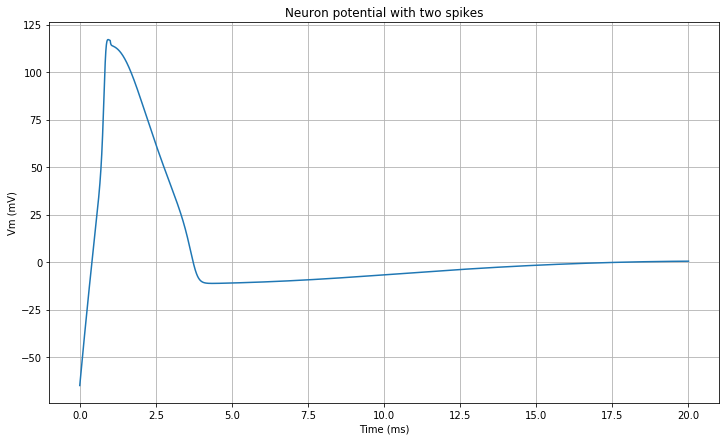

In [7]:
# Set random seed (for reproducibility)
np.random.seed(1000)
    
t_vector = np.linspace(0.0, 20.0, 10000)
y_matrix = compute_y_matrix(t_vector, CurrentFunctions.Id_q1, IonsConstants.c_m, Neuron(-65.0))

# membrane potential graph
HHGraphs.show_vm_t_graph(t_vector, y_matrix[:, 0])

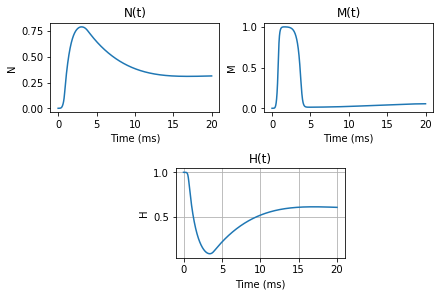

In [8]:
# N(t), M(t) and H(t) graphs
HHGraphs.show_ions_p_t_graphs(t_vector, y_matrix[:, 1], y_matrix[:, 2], y_matrix[:, 3])

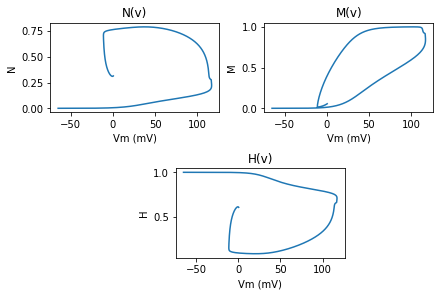

In [9]:
# N(v), M(v) and H(v) graphs
HHGraphs.show_ions_p_vm_graphs(y_matrix[:, 0], y_matrix[:, 1], y_matrix[:, 2], y_matrix[:, 3])

### Relation of the external current to the HH model firing rate

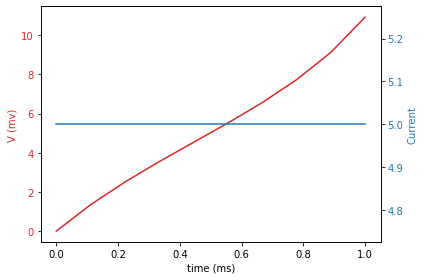

In [10]:
t_vector = np.linspace(0.0, 1.0, 10)
y_matrix = compute_y_matrix(t_vector, 
                            CurrentFunctions.Id_q4_a, 
                            2 * math.pi * 0.2 * 0.3,
                            Neuron(0, CurrentFunctions.Id_q4_a))
i_vector = [CurrentFunctions.Id_q4_a(None)] * 10

# graphs v(t) and i(t) for constant i
HHGraphs.show_vt_it_graph(t_vector, i_vector, y_matrix[:, 0])

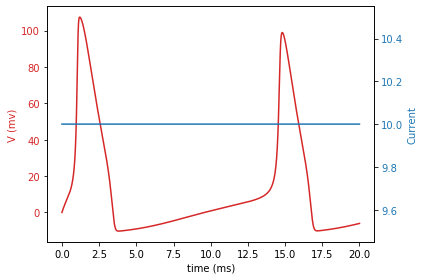

In [11]:
t_vector = np.linspace(0.0, 20.0, 10000)
y_matrix = compute_y_matrix(t_vector, 
                            CurrentFunctions.Id_q4_b,
                            2 * math.pi * 0.2 * 0.3, 
                            Neuron(0,CurrentFunctions.Id_q4_b))
i_vector = [CurrentFunctions.Id_q4_b(None)] * 10000

# graphs v(t) and i(t) for enader val of constant i
HHGraphs.show_vt_it_graph(t_vector, i_vector, y_matrix[:, 0])

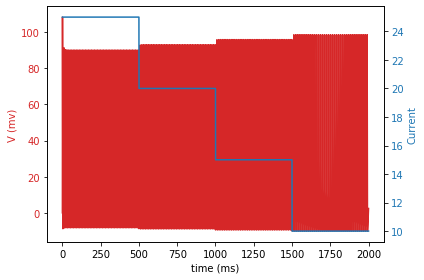

In [12]:
t_vector = np.linspace(0.0, 2000.0, 1000000)
y_matrix = compute_y_matrix(t_vector, 
                            CurrentFunctions.Id_q5_c, 
                            2 * math.pi * 0.2 * 0.3, 
                            Neuron(0,CurrentFunctions.Id_q5_c))
i_vector = CurrentFunctions.create_i_vector_q5(t_vector)

# graphs v(t) and i(t) for constant i
HHGraphs.show_vt_it_graph(t_vector, i_vector, y_matrix[:, 0])